In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
import datetime as dt
import math
import numpy as np
import osr
from osgeo import gdal
from IPython.display import display, clear_output
%matplotlib inline

# global variables
spectral_bands = ['blue','green','red','nir','swir1','swir2']

# function to get arealstatistik data collection year for campaign and roi
def collection_year(roi,yearAS):
    
    if yearAS == 2004:
        if roi=='roi1': return 2007
        if roi=='roi2': return 2006
        if roi=='roi3': return 2004
    if yearAS == 2013:
        if roi=='roi1': return 2016
        if roi=='roi2': return 2015
        if roi=='roi3': return 2013


def save_geotiff(ds,fname):
    
    dst_ds = gdal.GetDriverByName('GTiff').CreateCopy(fname+'.tif', ds)
    dst_ds = None


# function to read in a data cube from a geo tiff file
def geotiff2datacube(fname):

    ds = gdal.Open(fname)
    
    geotransform = ds.GetGeoTransform()
    
    proj = osr.SpatialReference(wkt=ds.GetProjection())
    epsg = int(proj.GetAttrValue('AUTHORITY',1))
    
    xy_shape = np.array(ds.GetRasterBand(1).ReadAsArray()).shape
    
    # get number of bands in raster file
    n_bands = ds.RasterCount
    
    # initialize a data cube
    xyz_shape = xy_shape + (n_bands,)
    data_cube = np.ndarray(xyz_shape)
    
    # fill it with bands
    for i in range(1,n_bands+1):
        data_cube[:,:,i-1] =  np.array(ds.GetRasterBand(i).ReadAsArray())
    
    return data_cube, geotransform, epsg
    # end of read in datacube function


def datacube2geotiff(data_cube,geotransform,epsg):
    
    n_rows, n_cols, n_bands = data_cube.shape
    
    # open geo tiff file
    ds = gdal.GetDriverByName('GTiff').Create('placeholder.tif',n_cols, n_rows, n_bands, gdal.GDT_Float32)
    ds.SetGeoTransform(geotransform)
    
    # set crs
    srs = osr.SpatialReference()
    srs.ImportFromEPSG(epsg)
    ds.SetProjection(srs.ExportToWkt())
    
    # write data cube to geo tiff
    for i_band in range(n_bands):
        ds.GetRasterBand(i_band+1).WriteArray(data_cube[:,:,i_band])
    
    return ds

def convert_date(date):
    ref = dt.datetime(1970,1,1)
    diff = (date-ref).days/365.24
    return diff*2*math.pi
 


def coefficients2value(coefficients, doy, year):
   
    n_harmonics = 1
    
    str_year = str(year)
    str_doy = str(doy)
    for _ in range(3-len(str_doy)): str_doy = '0'+str_doy
    
    date = dt.datetime.strptime(f'{str_doy} {str_year}', '%j %Y')
    date = convert_date(date)
    
    # compute independents
    cos_independents = [math.cos(date*freq) for freq in range(1,n_harmonics+1)]
    sin_independents = [math.sin(date*freq) for freq in range(1,n_harmonics+1)]
    
    # add constant
    value = coefficients[0]
    # add harmonics
    for i in range(n_harmonics):
        cos_index = 1+i
        sin_index = 1+n_harmonics+i
        value += cos_independents[i]*coefficients[cos_index]
        value += sin_independents[i]*coefficients[sin_index]
        
    return int(value)
 
def coefficients2image(coefficients_file, doy, year):

    print(f'Generating synthetic image (Year: {year}, DOY: {doy})')
    
    coefficients, geotransform, epsg = geotiff2datacube(coefficients_file)
    # coefficients = coefficients[0:5,0:5]
        
    # initialize image
    shape = list(coefficients.shape)
    shape[2] = len(spectral_bands)
    image = np.zeros(tuple(shape))
    
    # progress report
    n_pixels = shape[0]*shape[1]
    step = n_pixels//10
    
    # loop over all pixels
    for index, _ in np.ndenumerate(image):
        irow, icol, iband = index
        value = coefficients2value(coefficients[irow,icol,iband*3:iband*3+3],doy,year)
        image[irow,icol,iband] = value
        
        # cap
        if value<0: image[irow,icol,iband]=0
        if value>10000: image[irow,icol,iband]=10000
        

        # report progress
        curr_pixel = irow*shape[1]+icol
        if curr_pixel!=0 and curr_pixel%step==0:
            clear_output(wait=True)
            display(f'{int(curr_pixel/n_pixels*100)+1}%')
        
    return image, geotransform, epsg


def valid_coefficients(visual_coefficients, year):
    visual_values = []
    for coefficients in visual_coefficients:
        # const = coefficients[0]
        # a, b = coefficients[1:]
        # amplitude = np.sqrt(np.power(a,2)+np.power(b,2))
        # max_ = const+amplitude
        # min_ = const-amplitude
        # visual_values.extend([max_,min_])
        band_values = [coefficients2value(coefficients,doy,year) for doy in [28,91,182,273,336]]
        visual_values.extend(band_values)
    valid = [False for value in visual_values if value<0 or value>5000]
    return all(valid)
    
    
def assemble_coefficients(path, roi, year):
    
    composite, _, _ = geotiff2datacube(f'{path}composite_{roi}_{year}.tif')
    count, geotransform, epsg = geotiff2datacube(f'{path}count_min_{roi}_{year}.tif')
    
    # read in harmonic coefficients, medians and counts for all spectral bands 
    coefs = []
        
    for band in spectral_bands:    
        coef, _, _ = geotiff2datacube(f'{path}coefficients_{roi}_{year}_{band}.tif')
        coefs.append(coef)
    
    
    # initialize model
    xyz_shape = list(count.shape)
    model = np.ndarray(tuple(xyz_shape), dtype=np.uint8)
    
    # initialize coefficients
    xyz_shape[2] = len(spectral_bands)*3
    coefficients = np.zeros(tuple(xyz_shape))
    
    # progress report
    n_pixels = xyz_shape[0]*xyz_shape[1]
    step = n_pixels//20
    
    
    # loop over all pixels
    for index, c in np.ndenumerate(count):
        irow = index[0]
        icol = index[1]
        
        # apply model according to count for each spectral band     
        for iband, band in enumerate(spectral_bands):
            
            if c>12:
                coefficients[irow,icol,iband*3:iband*3+3] = coefs[iband][irow,icol,:]
                model[irow,icol,0] = 2
            else:
                coefficients[irow,icol,iband*3] = composite[irow,icol,iband]
                model[irow,icol,0] = 1
            # end of loop over spectral bands
            
        
        # postprocessing
        # for harmonic models, check the coefficient's validity
        if c>12:
            
            coefficients_bgr = [coefficients[irow,icol,0:3],coefficients[irow,icol,3:6],coefficients[irow,icol,6:9]]
            valid = valid_coefficients(coefficients_bgr,year)  
            
            if not valid:
                for iband in range(len(spectral_bands)):
                    coefficients[irow,icol,iband*3:iband*3+3] = [0 for i in range(3)] 
                    coefficients[irow,icol,iband*3] = composite[irow,icol,iband]
                    model[irow,icol,0] = 1
         
        # for median models, cap values
        if c<12:
            for iband in range(len(spectral_bands)):
                if coefficients[irow,icol,iband*3]<0: coefficients[irow,icol,iband*3]=0
                if coefficients[irow,icol,iband*3]>10000: coefficients[irow,icol,iband*3]=10000

        # report progress
        curr_pixel = irow*xyz_shape[1]+icol
        if curr_pixel!=0 and curr_pixel%step==0:
            clear_output(wait=True)
            display(f'{roi.upper()}: {int(curr_pixel/n_pixels*100)+1}%')
        
        # end of loop over pixels
        
    print()
    
    return coefficients, model, geotransform, epsg
    
    # end of generate image at doy function
    


In [3]:
# these parameters can be changed

# run for different region of interests
rois = ['roi1','roi2','roi3']
# rois = ['roi3']
yearAS = 2013 # 2004 or 2013

# path to data
path_components = f'data/gee_components/'
path_images = f'data/coefficients/'
    
    
for roi in rois:
    
    year = collection_year(roi,yearAS)
    
    coefficients, model, geotransform, epsg = assemble_coefficients(path_components,roi,year)

    coefficients_ds = datacube2geotiff(coefficients,geotransform,epsg)
    save_geotiff(coefficients_ds,f'{path_images}coefficients_{roi}_{year}')    

    model_ds = datacube2geotiff(model,geotransform,epsg)
    save_geotiff(model_ds,f'{path_images}model_{roi}_{year}')


'ROI3: 100%'

'100%'

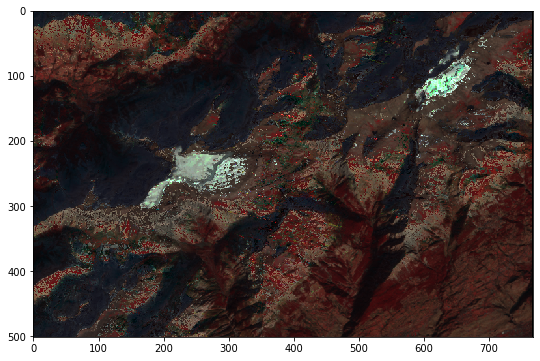

In [5]:
roi = 'roi3'
yearAS = 2004 # 2004 or 2013
# year of data acquisition
year = collection_year(roi,yearAS)

    # path to data
path_components = f'data/gee_components/'
path_images = f'data/coefficients/'

doy = 10

coefficients_file = f'{path_images}coefficients_{roi}_{year}.tif'
image, geotransform, epsg = coefficients2image(coefficients_file, doy, year)

image_rescaled = np.true_divide(image, 10000)

xyz_shape = (image_rescaled.shape[0], image_rescaled.shape[1], 3)
rgb_cube = np.ndarray(xyz_shape)
rgb_cube[:,:,0] = image_rescaled[:,:,3]
rgb_cube[:,:,1] = image_rescaled[:,:,2]
rgb_cube[:,:,2] = image_rescaled[:,:,1]

fig, ax = plt.subplots(figsize=(10,6))   
plt.imshow(rgb_cube)

[-0.5  0.5  1.5  2.5] [0. 1. 2.]


[Text(1, 0, 'Constant (median all observations)'),
 Text(1, 0, 'Constant (median clear observations)'),
 Text(1, 0, 'Constant + harmonic model')]

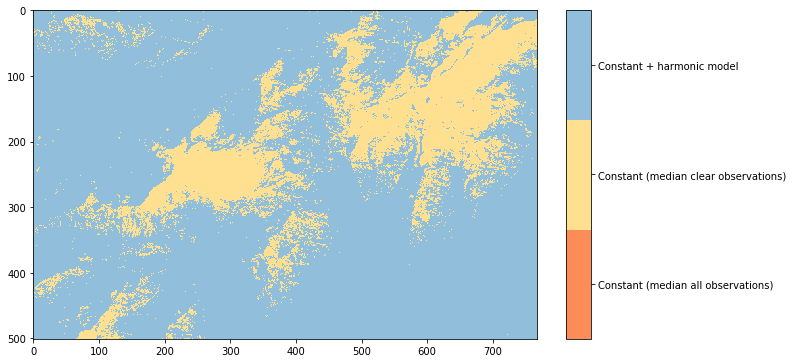

In [13]:

roi = 'roi3'

yearAS = 2004 # 2004 or 2013
    
# year of data acquisition
year = collection_year(roi,yearAS)

model, _, _ = geotiff2datacube(f'{path_images}model_{roi}_{year}.tif')


classes = [
    'Constant (median all observations)',
    'Constant (median clear observations)',
    'Constant + harmonic model',
]


hex_colors = [
    '#fc8d59',
    '#fee090',
    '#91bfdb',
]

ticks = np.arange(-0.5,3)
tick_labels = np.linspace(0,2,3)

print(ticks,tick_labels)
cmap = mpl.colors.ListedColormap(hex_colors)
norm = mpl.colors.BoundaryNorm(ticks, cmap.N)
        
fig, ax = plt.subplots(figsize=(10,10))        
im = ax.imshow(model[:,:,0], cmap=cmap, norm=norm)

divider = make_axes_locatable(ax)
cax = divider.new_horizontal(size="5%", pad=0.4, pack_start=False)
fig.add_axes(cax)
cbar = fig.colorbar(im, cax=cax, orientation="vertical", ticks=tick_labels)
cbar.ax.set_yticklabels(classes)

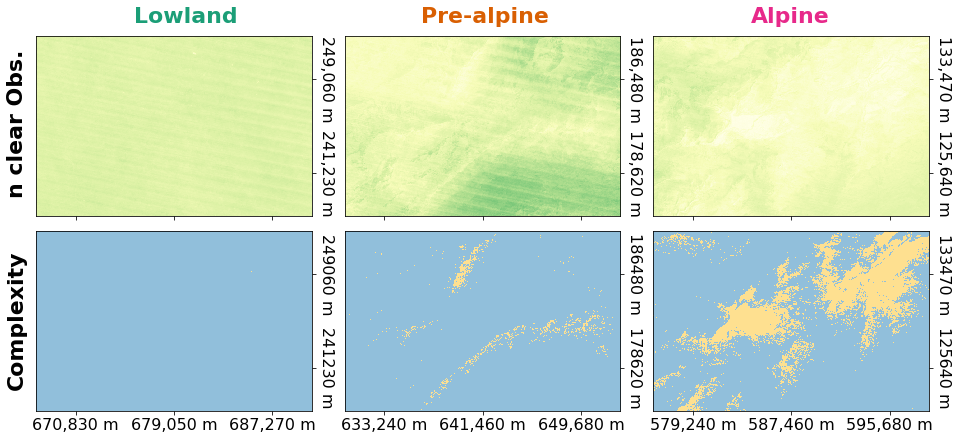

In [4]:
""" //////////////////////// plotting models //////////////////////// """

def plot_model(ax,fname,show_xlabels=True,show_ylabels=True):
    
    model, geotransform, epsg = geotiff2datacube(fname)
    xyz_shape = (model.shape[0], model.shape[1], 1)
    
    colors = ['#fc8d59','#fee090','#91bfdb']
    cmap = mpl.colors.ListedColormap(colors)
    norm = mpl.colors.BoundaryNorm(np.arange(-0.5,3), cmap.N)
    
    im = ax.imshow(model[:,:,0], cmap=cmap, norm=norm)
    
    # label axes according to geotransform
    x_start, x_res, _, y_start, _, y_res = geotransform

    # x axis
    x_offset = 110
    x_ticks = [0+x_offset,xyz_shape[1]//2,xyz_shape[1]-x_offset]
    x_labels = [f'{x_start+x_res*i:,.0f} m' for i in x_ticks]
    x_labels = [f'{x_start+x_res*i:,.0f} m' for i in x_ticks] if show_xlabels==True else []
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_labels,fontdict={'fontsize': fontsize})
    
    # y axis
    y_offset = 120
    y_ticks = [0+y_offset,xyz_shape[0]-y_offset]
    y_labels = [f'{y_start+y_res*i:.0f} m' for i in y_ticks] if show_ylabels==True else []
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position("right")
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_labels, rotation=270, va="center", fontdict={'fontsize': fontsize})
    
    
    return im
    # end of function
    
    
def plot_count(ax,fname,limits,show_xlabels=True,show_ylabels=True):
    
    count, geotransform, epsg = geotiff2datacube(fname)
    xyz_shape = (count.shape[0], count.shape[1], 1)
    
    colors = ['#000000','#fffff']
    
    cmap = mpl.cm.get_cmap(name='YlGn')
    
    im = ax.imshow(count[:,:,0],cmap=cmap)
    im.set_clim(*limits)
    # label axes according to geotransform
    x_start, x_res, _, y_start, _, y_res = geotransform

    # x axis
    x_offset = 110
    x_ticks = [0+x_offset,xyz_shape[1]//2,xyz_shape[1]-x_offset]
    x_labels = [f'{x_start+x_res*i:,.0f} m' for i in x_ticks] if show_xlabels==True else []
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_labels,fontdict={'fontsize': fontsize})
    
    # y axis
    y_offset = 120
    y_ticks = [0+y_offset,xyz_shape[0]-y_offset]
    y_labels = [f'{y_start+y_res*i:,.0f} m' for i in y_ticks] if show_ylabels==True else []
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position("right")
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_labels, rotation=270, va="center", fontdict={'fontsize': fontsize})
    
    
    return im
    # end of function
    
    
    return
    

# run for different region of interests 
yearAS = 2004
rois = ['roi1','roi2','roi3']
roi_names = ['Lowland','Pre-alpine','Alpine']
roi_colors = ['#1b9e77','#d95f02','#e7298a']

# path to data
folder_models = 'data/coefficients/'
folder_count = 'data/gee_components/'

fontsize_title = 22
fontsize = 16

fig, axs = plt.subplots(2,3, figsize=(16,7), facecolor='w', edgecolor='k') #sharey=True
plt.rcParams.update({'font.size': fontsize})
fig.subplots_adjust(hspace=0.05, wspace=0.12)
axs = axs.ravel()

for iroi, roi in enumerate(rois):
    
    plot_count(axs[iroi],f'{folder_count}count_min_{roi}_{collection_year(roi,yearAS)}.tif',(0,200),False)
    plot_model(axs[iroi+3],f'{folder_models}model_{roi}_{collection_year(roi,yearAS)}.tif')

fig.text(0.1, 0.7, 'n clear Obs.', va='center', rotation='vertical',fontweight='bold',fontsize=fontsize_title)
fig.text(0.1, 0.31, 'Complexity', va='center', rotation='vertical',fontweight='bold',fontsize=fontsize_title)
    
fig.text(0.255, 0.9, roi_names[0], ha='center',fontweight='bold',fontsize=fontsize_title,color='#1b9e77')
fig.text(0.515, 0.9, roi_names[1], ha='center',fontweight='bold',fontsize=fontsize_title,color='#d95f02')
fig.text(0.78, 0.9, roi_names[2], ha='center',fontweight='bold',fontsize=fontsize_title,color='#e7298a')

plt.savefig(f'plots/counts_models_as{yearAS}.png', dpi=300, bbox_inches = "tight")

C:\Users\User\Anaconda3\envs\env\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  app.launch_new_instance()


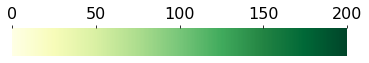

In [6]:
import matplotlib.pyplot as plt
import matplotlib as mpl

fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)

cmap = mpl.cm.get_cmap(name='YlGn')
norm = mpl.colors.Normalize(vmin=0, vmax=200)

cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                orientation='horizontal',ticklocation='top')
cb1.outline.set_visible(False)
#cb1.set_label('Clear observation count')
plt.savefig(f'plots/legend_nobservation.png', dpi=300, bbox_inches = "tight")
fig.show()

In [3]:
# old assemble coefficients function (still with perpetual snow and median)

def assemble_coefficients(path, roi, year):
    
    median, _, _ = geotiff2datacube(f'{path}median_{roi}_{year}.tif')
    perpetual_snow, _, _ = geotiff2datacube(f'{path}perpetual_snow_{roi}_{year}.tif')
    count, geotransform, epsg = geotiff2datacube(f'{path}count_min_{roi}_{year}.tif')
    
    # read in harmonic coefficients, medians and counts for all spectral bands 
    coefs = []
        
    for band in spectral_bands:    
        coef, _, _ = geotiff2datacube(f'{path}coefficients_{roi}_{year}_{band}.tif')
        coefs.append(coef)
    
    
    # initialize model
    xyz_shape = list(count.shape)
    model = np.ndarray(tuple(xyz_shape), dtype=np.uint8)
    
    # initialize coefficients
    xyz_shape[2] = len(spectral_bands)*3
    coefficients = np.zeros(tuple(xyz_shape))
    
    # progress report
    n_pixels = xyz_shape[0]*xyz_shape[1]
    step = n_pixels//20
    
    
    # loop over all pixels
    for index, c in np.ndenumerate(count):
        irow = index[0]
        icol = index[1]
        
        # apply model according to count for each spectral band     
        for iband, band in enumerate(spectral_bands):
            
            if perpetual_snow[irow,icol,0]==1:
                coefficients[irow,icol,iband*3] = median[irow,icol,iband]
                model[irow,icol,0] = 0
            else:
                if c>12:
                    coefficients[irow,icol,iband*3:iband*3+3] = coefs[iband][irow,icol,:]
                    model[irow,icol,0] = 2
                else:
                    coefficients[irow,icol,iband*3] = median[irow,icol,iband]
                    model[irow,icol,0] = 1
            # end of loop over spectral bands
            
        
        # postprocessing
        # for harmonic models, check the coefficient's validity
        if c>12 and perpetual_snow[irow,icol,0]==0:
            
            coefficients_bgr = [coefficients[irow,icol,0:3],coefficients[irow,icol,3:6],coefficients[irow,icol,6:9]]
            valid = valid_coefficients(coefficients_bgr,year)  
            
            if not valid:
                for iband in range(len(spectral_bands)):
                    coefficients[irow,icol,iband*3:iband*3+3] = [0 for i in range(3)] 
                    coefficients[irow,icol,iband*3] = median[irow,icol,iband]
                    model[irow,icol,0] = 1
         
        # for median models, cap values
        if c<12 or perpetual_snow[irow,icol,0]==1:
            for iband in range(len(spectral_bands)):
                if coefficients[irow,icol,iband*3]<0: coefficients[irow,icol,iband*3]=0
                if coefficients[irow,icol,iband*3]>10000: coefficients[irow,icol,iband*3]=10000

        # report progress
        curr_pixel = irow*xyz_shape[1]+icol
        if curr_pixel!=0 and curr_pixel%step==0:
            clear_output(wait=True)
            display(f'{roi.upper()}: {int(curr_pixel/n_pixels*100)+1}%')
        
        # end of loop over pixels
        
    print()
    
    return coefficients, model, geotransform, epsg
    
    # end of generate image at doy function
    
    



In [42]:
# short analysis for model complexity

# path to data
folder_models = 'data/coefficients/'
folder_counts = 'data/gee_components/'

yearsAS = [2004,2013]
rois = ['roi1','roi2','roi3']


for roi in rois:
    print(roi)
    for year in yearsAS:
        
        count, _, _ = geotiff2datacube(f'{folder_counts}count_min_{roi}_{collection_year(roi,year)}.tif')
        print(f'Mean: {np.mean(np.mean(count)):.0f}, Std: {np.std(count):.0f}, Min: {np.min(np.min(count)):.0f}, Max: {np.max(np.max(count)):.0f}')
        
        model, _, _ = geotiff2datacube(f'{folder_models}model_{roi}_{collection_year(roi,year)}.tif')
        arr = np.histogram(model,bins=[1,2,3])[0]
        percentage = 100/arr[1]*arr[0]
        print(arr,f'{100-percentage:.1f}')
        
        
        
        
        
        print()


roi1
Mean: 45, Std: 3, Min: 15, Max: 57
[     4 384764] 100.0

Mean: 148, Std: 7, Min: 97, Max: 174
[     2 384766] 100.0

roi2
Mean: 46, Std: 19, Min: 0, Max: 103
[  9995 375541] 97.3

Mean: 131, Std: 39, Min: 0, Max: 229
[  6368 379168] 98.3

roi3
Mean: 26, Std: 11, Min: 0, Max: 62
[ 83622 301146] 72.2

Mean: 25, Std: 14, Min: 0, Max: 72
[107292 277476] 61.3



In [36]:



arr = np.array([[1,2],[3,4]])
np.std(arr)

1.118033988749895